## Installation

###  Installing Anaconda navigator to set up jupyter notebook environment (you can skip this if you already can run jupyter notebooks in an environment)

- A recommended short 5 min youtube video on setting up jupyter notebook can be found [here](https://www.youtube.com/watch?v=Gq167zHsuA0),(https://www.youtube.com/watch?v=Gq167zHsuA0) \
  The main steps: 
    - Install [Anaconda navigator](https://www.anaconda.com/download/success), select a graphical installer
    - Create an environment. `Environments` on left menu-> `create` option at the bottom -> name the new environment and `create`. Python version should be 3.9 or more recent (recommended is 3.9). You can find the documentation [here](https://docs.anaconda.com/navigator/getting-started/). 
    - Install jupyter notebooks in the environment. `Home` on the left menu -> check if you are on the new environment, the name should be selected on the dropdown menu after `on` on the top of the page -> Click on `install` under the jupyter notebooks icon.
    - Click on `launch` under the  jupyter notebooks icon and navigate to this workshop notebook and proceed to install the packages.
    



### Installing scvi-tools and some other packages 


In [1]:
# Only need to run this once, installs the necessary packages, this will take a few minutes
import sys
!{sys.executable} -m pip install scanpy scvi-tools seaborn scikit-misc igraph leidenalg
# Typically, it's better practice to perform conda installations when using conda environments as we are,
# but if we don't have too many dependencies we get away with pip installations 

You will need to restart the kernel after installing the packages (Kernel (toolbar/header bar) -> restart kernel )

# Introduction to scvi-tools

Adapted from https://docs.scvi-tools.org/en/stable/tutorials/notebooks/quick_start/api_overview.html

In this workshop we will introduce `anndata` object, perform simple QC, train an scVI model with the subsampled heart atlas, inspect scVI batch correction and perform clustering analysis.

$\otimes$  indicates advanced/extra topics

All references are at the end of the notebook.


## Brief introduction to scRNA-seq/snRNA-seq data 

Single-cell RNA sequencing (scRNA-seq) and single-nucleus RNA sequencing (snRNA-seq) are technologies that provide high-dimensional snapshots of gene expression at the resolution of individual cells or nuclei. 

The gene expression is measured by capturing the from the whole cell (cytoplasm + nuclei) in scRNA-seq or from just the nucleus in snRNA-seq.  The image below shows a simple depiction of an animal cell with the nucleus. 

<div style="max-width:300px; margin: 0 auto; text-align: center;">

![](figures/animal_cell.png)Fig. 1

</div>

The data is a matrix where the columns (samples) represent different cells/nuceli and the rows (features) are the different genes.  

<div style="max-width:300px; margin: 0 auto; text-align: center;">

![](figures/data_counts_matrix.png) 
Fig. 2

$$  C_{ij}= \text{read counts that measures gene expression of the }  j\text{-th gene in the }i\text{-th cell/nuclei }$$

</div>


### Brief introduction to batch effects

Batch effects are systematic technical variations introduced during different stages of sample processing, such as cell isolation, library preparation, or sequencing. These effects can arise from differences in reagents, equipment, operators, or sequencing runs, causing data discrepancies between batches that do not reflect true biological differences. If uncorrected, batch effects can obscure biological signals, bias downstream analyses, and mislead interpretations. Batch correction aim to remove this technical unwanted variation from effecting downstream analysis.
<div style="max-width:400px; margin: 0 auto; text-align: center;">

![](figures/batch_effects.png)
Fig. 3

</div>

More detailed discussion on batch correction can be found [here](https://www.10xgenomics.com/analysis-guides/introduction-batch-effect-correction). 


In [2]:
import warnings
warnings.filterwarnings('ignore') # suppresses warning messages 

# Loading necessary modules
import os
import tempfile
import scanpy as sc
import scvi
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from IPython.display import display

In [3]:
# Setting random seed to 0

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.6


In [4]:
# Ensures high precision for torch operations
torch.set_float32_matmul_precision("high")

# Creates temporary folder to save the data
save_dir = tempfile.TemporaryDirectory()

# presets certain figure parameters 
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Loading and preparing data

Let us first load a subsampled version of the heart cell atlas dataset described in Litviňuková et al. (2020). scvi-tools has many "built-in" datasets as well as support for loading arbitrary `.csv`, `.loom`, and `.h5ad` (AnnData) files. The scvi-tools documentation (https://docs.scvi-tools.org/en/stable/index.html) is well written and extensive.  

### Download and load the data

In [32]:
# download the data to the temporary directory
adata = scvi.data.heart_cell_atlas_subsampled(save_path=save_dir.name)
adata

INFO     File /var/folders/f7/q0k9_2l97fl8sqsbwh_ff_4r0000gn/T/tmpqufaee40/hca_subsampled_20k.h5ad already         
         downloaded                                                                                                


AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

 ### The data is loaded as an `annData` (annotated data) object.

Why do we need `annData` object? The snRNA-seq data contains various types of information beyond the count data matrix, $[C_{ij}]$. We also have information about the cells (cell source, cell type, gender of the donor, etc.) and also gene specific information (gene symbols, Ensembl ID - a unique gene identifier as gene symbols are not unique). The `annData` object provides an organised and efficient way to store and integrate these diverse data types into a single, structured entity for streamlined analysis. 

 The figure below illustrated the structure of the `annData` object. In essence it is a concise way fo saving the data matrix (single-cell RNA-seq counts) along with the information about the variables (genes) and observations (cells).


<div style="max-width:500px; margin: 0 auto; text-align: center;">

![](figures/anndata_image.png)

Fig. 4
</div>


 - Information about the genes (variables) are found in the `var` slot of the object (accessed via `.var`). The `varm` slot is a multidimensional version of `var`.

 - Information about the cells (observations) are found in the `obs` slot of the object (accessed via `.obs`). The `obsm` slot is a multidimensional version of `obsm`.

 - Information with the same dimensionalities as the data is stored in `layers`, this includes transformed/normalised data that we compute. 

 - Other unstructured annotations are found in the `uns` slot (via `.uns`), including information about dimensionality reduction or other calculations that have been performed on the object.

 - The `.raw` attribute (not depicted in the image) is used to store an unmodified version of the data matrix (and its associated metadata) within the `annData` object, allowing the original data to be safely preserved before modifications are applied during analysis.


## Acessing data and information from `annData` object

In [33]:
print('Data matrix of counts')
counts_matrix = adata.X.todense() # the matrix C_ij
print(counts_matrix)
print('Shape of the counts matrix', counts_matrix.shape)

Data matrix of counts
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape of the counts matrix (18641, 26662)


In [34]:
print(' \n Cell/observations information')
display(adata.obs)

 
 Cell/observations information


,NRP,age_group,cell_source,cell_type,donor,gender,n_counts,n_genes,percent_mito,percent_ribo,region,sample,scrublet_score,source,type,version,cell_states,Used
AACTCCCCACGAGAGT-1-HCAHeart7844001,Yes,65-70,Sanger-CD45,Myeloid,D6,Male,1420.0,738,0.054930,0.064789,LA,HCAHeart7844001,0.113475,CD45+,DCD,V2,LYVE1+MØ1,Yes
ATAACGCAGAGCTGGT-1-HCAHeart7829979,No,70-75,Sanger-Nuclei,Ventricular_Cardiomyocyte,D4,Female,844.0,505,0.001185,0.001185,RV,HCAHeart7829979,0.085546,Nuclei,DCD,V2,vCM1,Yes
GTCAAGTCATGCCACG-1-HCAHeart7702879,Yes,60-65,Sanger-Nuclei,Fibroblast,D2,Male,1491.0,862,0.000000,0.005366,RA,HCAHeart7702879,0.197861,Nuclei,DCD,V2,FB2,Yes
GGTGATTCAAATGAGT-1-HCAHeart8102858,Yes,60-65,Sanger-CD45,Endothelial,D11,Female,2167.0,1115,0.064144,0.027227,LA,HCAHeart8102858,0.113475,CD45+,DCD,V3,EC10_CMC-like,Yes
AGAGAATTCTTAGCAG-1-HCAHeart8102863,Yes,60-65,Sanger-Cells,Endothelial,D11,Female,7334.0,2505,0.093537,0.040496,RA,HCAHeart8102863,0.132150,Cells,DCD,V3,EC5_art,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGTCAGGCAAGGCTCC-1-HCAHeart7985087,No,55-60,Sanger-Nuclei,Ventricular_Cardiomyocyte,D3,Male,4478.0,2243,0.002233,0.001340,RV,HCAHeart7985087,0.185751,Nuclei,DBD,V2,vCM1,Yes
AGTCACAAGACGAGCT-1-H0035_RV,No,45-50,Harvard-Nuclei,Pericytes,H7,Female,967.0,630,0.002068,0.004137,RV,H0035_RV,0.081779,Nuclei,DBD,V3,PC1_vent,Yes
GGTGAAGGTTCCACAA-1-HCAHeart7844001,Yes,65-70,Sanger-CD45,Lymphoid,D6,Male,1599.0,619,0.041901,0.155722,LA,HCAHeart7844001,0.074830,CD45+,DCD,V2,CD4+T_tem,Yes
CAGCTAAGTACAGACG-1-HCAHeart7702876,Yes,60-65,Sanger-Nuclei,Atrial_Cardiomyocyte,D2,Male,3715.0,1523,0.000269,0.002423,LA,HCAHeart7702876,0.048649,Nuclei,DCD,V2,aCM3,Yes


The `adata.obs` contains information about the cells (the number of rows agrees with the first dimension of the counts matrix), for example one of the columns we will use is the `cell_source` which tells us the institute that processed the specific cell.

In [35]:
print('\n Genes/variables information')
display(adata.var) 


 Genes/variables information


,gene_ids-Harvard-Nuclei,feature_types-Harvard-Nuclei,gene_ids-Sanger-Nuclei,feature_types-Sanger-Nuclei,gene_ids-Sanger-Cells,feature_types-Sanger-Cells,gene_ids-Sanger-CD45,feature_types-Sanger-CD45,n_counts
AL627309.1,ENSG00000238009,Gene Expression,ENSG00000238009,0,ENSG00000238009,0,ENSG00000238009,0,249.0
AC114498.1,ENSG00000235146,Gene Expression,ENSG00000235146,0,ENSG00000235146,0,ENSG00000235146,0,28.0
AL669831.2,ENSG00000229905,Gene Expression,ENSG00000229905,0,ENSG00000229905,0,ENSG00000229905,0,3.0
AL669831.5,ENSG00000237491,Gene Expression,ENSG00000237491,0,ENSG00000237491,0,ENSG00000237491,0,1342.0
FAM87B,ENSG00000177757,Gene Expression,ENSG00000177757,0,ENSG00000177757,0,ENSG00000177757,0,15.0
...,...,...,...,...,...,...,...,...,...
AC007325.2,ENSG00000277196,Gene Expression,ENSG00000277196,0,ENSG00000277196,0,ENSG00000277196,0,68.0
BX072566.1,ENSG00000277630,Gene Expression,ENSG00000277630,0,ENSG00000277630,0,ENSG00000277630,0,4.0
AL354822.1,ENSG00000278384,Gene Expression,ENSG00000278384,0,ENSG00000278384,0,ENSG00000278384,0,476.0
AC004556.1,ENSG00000276345,Gene Expression,ENSG00000276345,0,ENSG00000276345,0,ENSG00000276345,0,151.0


Lets inspect the different cell type annotations present.

In [36]:
# Listing out the different cell type annotations 
list_of_sell_types  = adata.obs['cell_type'].cat.categories.tolist() 
print('List of cell types:', list_of_sell_types)

List of cell types: ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', 'Lymphoid', 'Mesothelial', 'Myeloid', 'Neuronal', 'Pericytes', 'Smooth_muscle_cells', 'Ventricular_Cardiomyocyte']


We will take a better look at the cell type annotations when we visualise the data.

<br>



### <font color='blue'>[Q]</font>   List the various age groups of the cells. 

In [37]:
# Solution
list_of_age_groups  = adata.obs['age_group'].cat.categories.tolist() 
print('List of cell types:', list_of_age_groups)

List of cell types: ['40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75']


## Pre-processing 

### Filtering uninformative genes

Genes that have a minimum count of $3$ are removed as they contain not information.

In [38]:
sc.pp.filter_genes(adata, min_counts=3)
adata # We see that the number of gene (n_vars) has decreased

AnnData object with n_obs × n_vars = 18641 × 26469
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

### Normalising the data 

Normalisation aims to remove the influence of technical effects in the expression profiles of cells. One major source of technical differences in scRNA-seq is library size (the sum of counts across all genes for a cell), which can be normalised using Scanpy's function [`.normalize_total()`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.normalize_total.html).

In [39]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

We perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. Highly variable genes are a measure to identify genes that vary in terms of gene expression across all cells present in the data set. We recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.  
$\otimes$  Discussions based on the selection of highly variable genes can be found in [Basics of Single-Cell Analysis with Bioconductor](https://bioconductor.org/books/3.15/OSCA.basic/feature-selection.html#hvg-selection).

In [40]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

 Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the `annData` object. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [41]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

## Creating and training a model
We create an scVI model with the adata object

In [42]:
model = scvi.model.SCVI(adata)

We can see an overview of the model by printing it

In [43]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

The number of epochs should be best $400$ or more for the scVI model, it's good practice to inspect the loss (ELBO) of the model to inspect if it's converged or not.

$\otimes$ scVI inference uses a concept of KL warmup (monotonic annealing scheduling) to $400$ epochs, thus it's better practice to use more than $400$ epochs. A discussion on this concept can be found in [Training trick for VAE](https://medium.com/@chengjing/a-must-have-training-trick-for-vae-variational-autoencoder-d28ff53b0023).

In [44]:
model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Load pre-trained model if the training process is too long

In [46]:
model = scvi.model.SCVI.load("scvi_model_heart_cell_atlas_subsampled", adata=adata)

INFO     File scvi_model_heart_cell_atlas_subsampled/model.pt already downloaded                                   


We can plot the loss values to inspect convergence

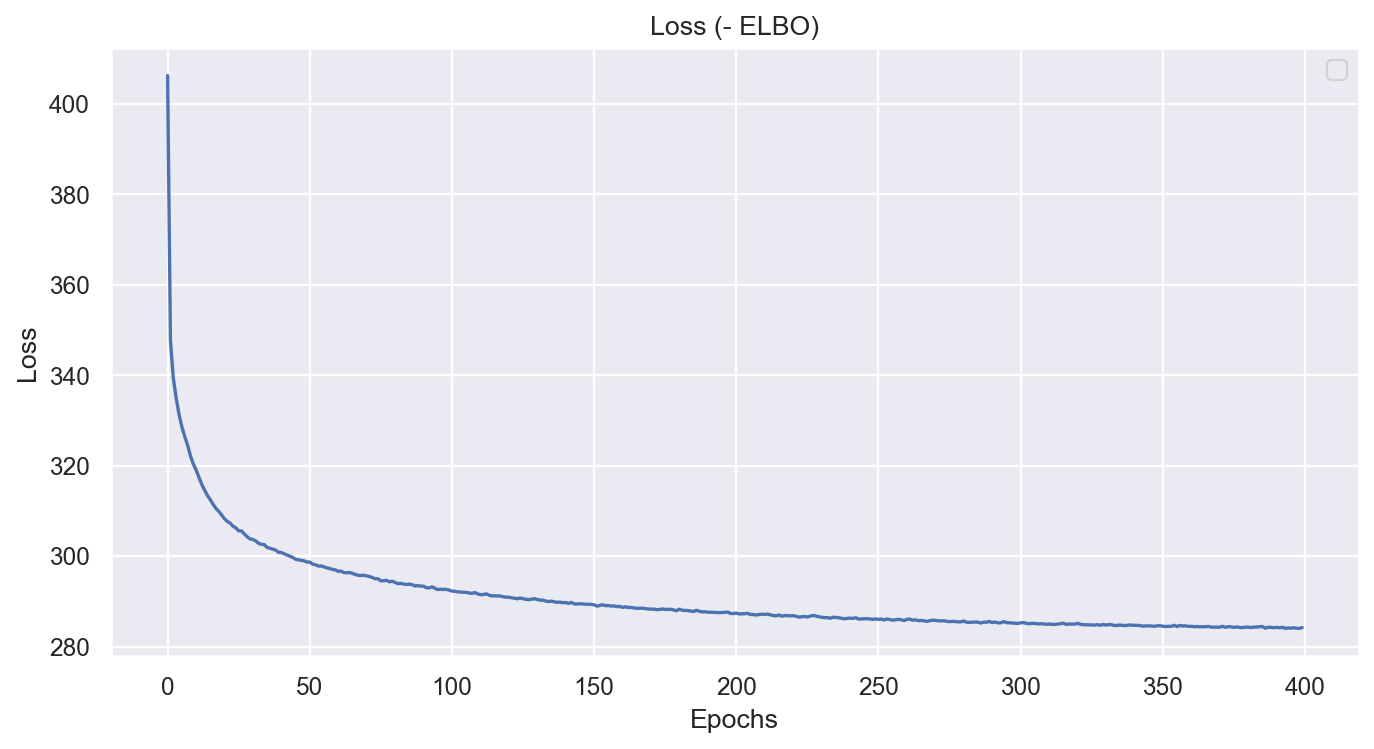

In [47]:
elbo_train = model.history['elbo_train']

plt.figure(figsize =(10,5))
plt.plot(elbo_train)
plt.title('Loss (- ELBO)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

## Saving and loading the scVI model

Saving the neural network weights of the model.

In [48]:
model_dir = os.path.join(save_dir.name, "scvi_model")
model.save(model_dir, overwrite=True) # overwrites = true, saves the model if already present 

In [49]:
model = scvi.model.SCVI.load(model_dir, adata=adata)

INFO     File /var/folders/f7/q0k9_2l97fl8sqsbwh_ff_4r0000gn/T/tmpqufaee40/scvi_model/model.pt already downloaded  


### Obtaining model outputs

It's often useful to store the outputs of scvi-tools back into the original annData object, as it permits interoperability with Scanpy.

In [50]:
SCVI_LATENT_KEY = "X_scVI"
latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(18641, 10)

In [51]:
denoised = model.get_normalized_expression(adata, library_size=1e4) # This by default has batch effects, but can be used for batch correction 
denoised.iloc[:5, :5]

,ISG15,TNFRSF18,VWA1,HES5,SPSB1
AACTCCCCACGAGAGT-1-HCAHeart7844001,15.071465,0.141500,0.404775,0.158858,1.025072
ATAACGCAGAGCTGGT-1-HCAHeart7829979,1.693512,0.001438,0.082798,0.001024,2.453596
GTCAAGTCATGCCACG-1-HCAHeart7702879,1.446016,0.170984,1.373141,0.025992,2.653909
GGTGATTCAAATGAGT-1-HCAHeart8102858,15.486287,0.029577,7.382153,0.149433,0.853203
AGAGAATTCTTAGCAG-1-HCAHeart8102863,4.052216,0.226639,2.579472,0.377051,4.119772


<br>

### <font color='blue'>[Q]</font>    Save the normalised expression as a adata object layer called "scvi_normalized"

In [23]:
# Solution
SCVI_NORMALIZED_KEY = "scvi_normalized"
adata.layers[SCVI_NORMALIZED_KEY] = model.get_normalized_expression(library_size=10e4) 
# If library_size is set as 'latent', then library size effects are present in the normalised counts
# This can also be used for batch corrected counts matrix. 

## Downstream analysis with Scanpy

### Visualisation without batch correction (PCA)

We use UMAP to *qualitatively* assess our low-dimension embeddings of cells. 

The embedding created by the scVI model can be treated as a replacement for PCA embeddings. 



In [30]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)


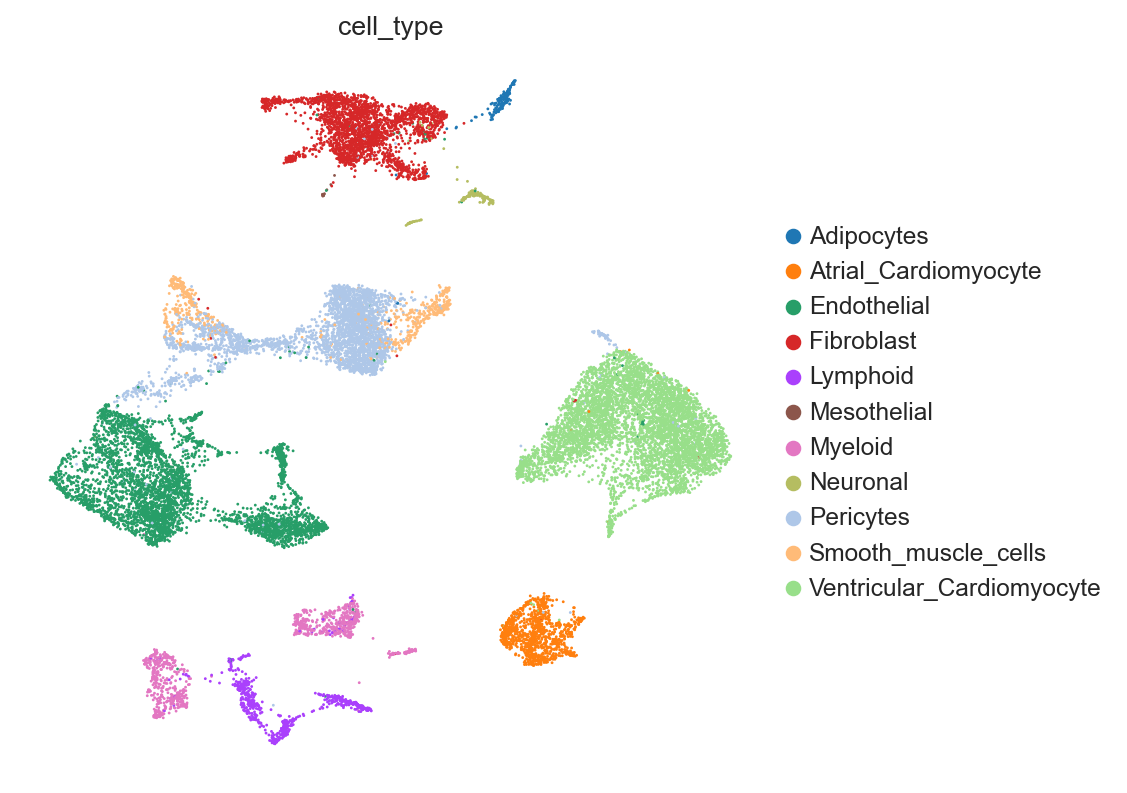

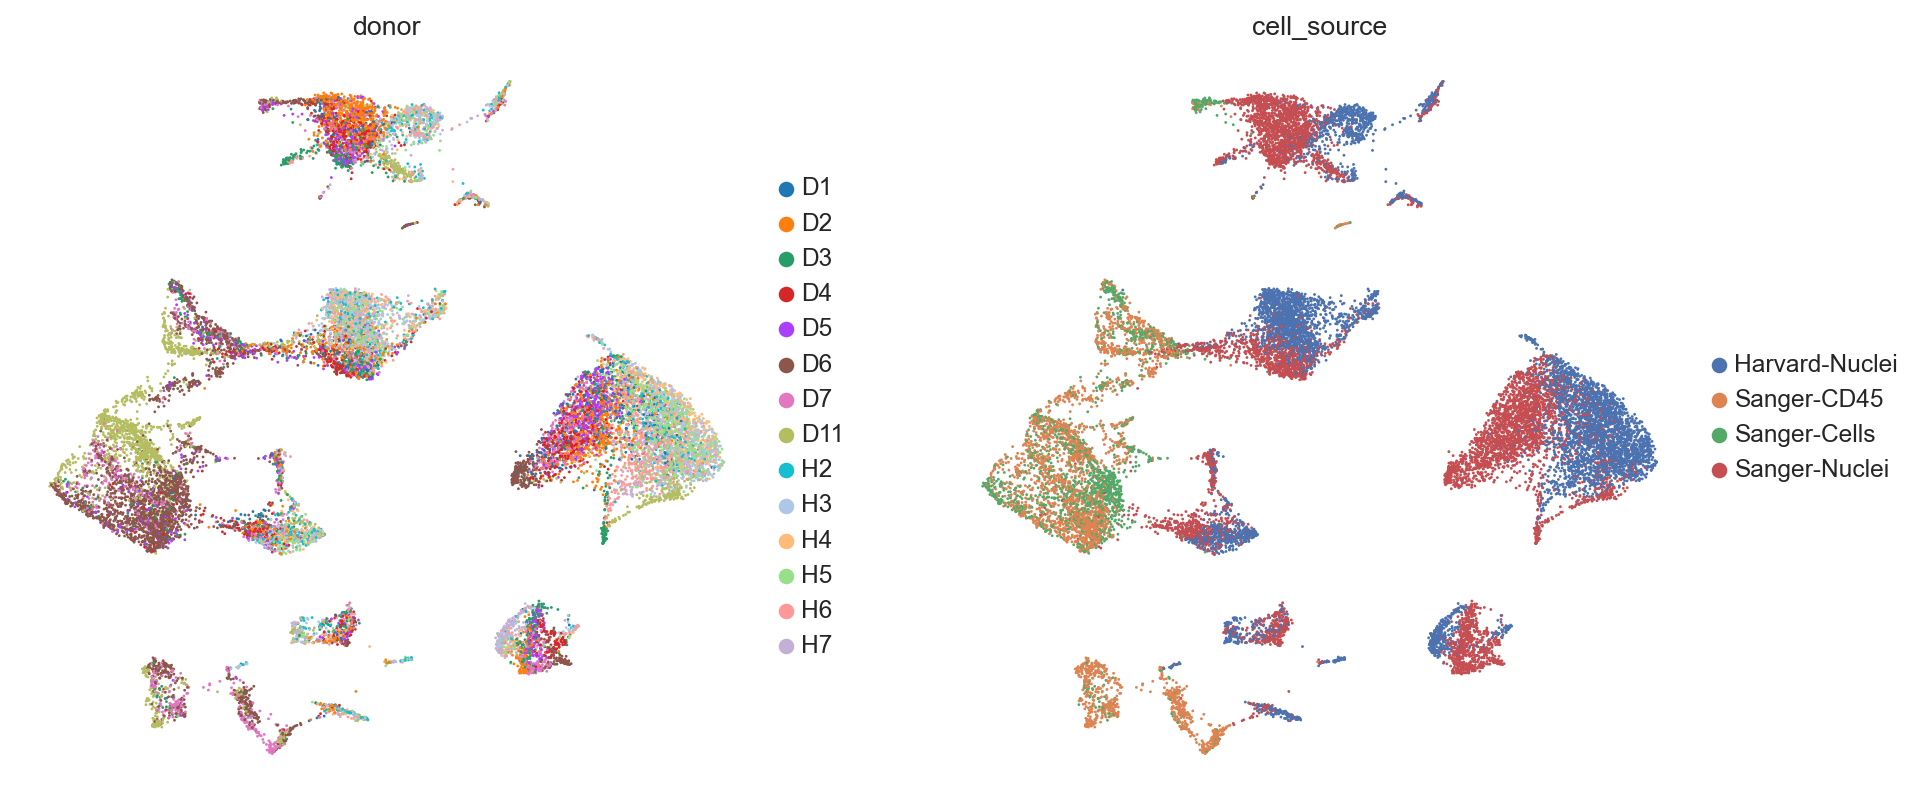

In [31]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

These cell types are the different types of cells that make the heart. 

<div style="max-width:400px; margin: 0 auto; text-align: center;">

![](figures/heart_cells.png)
Fig. 5
</div>


These different cells have different functions and which are integral to to proper functioning of the heart. To get a feel of the cells in our data set, lets look at the function of some of the cell types. <br><br>
- **Adipocytes** (fat cells) are specialized cells that store energy in the form of lipids (fat).<br><br>
- **Endothelial** cells make up the inner surface of blood vessels, including arteries, veins, and capillaries.<br><br>
- **Cardiomyocytes** (cardiac muscle cells) are contractile cells of the heart responsible for generating the force needed for the heart's rhythmic contractions, enabling blood circulation. **Atrial cardiomyocytes** are found in the upper chambers (atria), responsible for receiving blood from the body and lungs and pumping it into the ventricles. **Ventricular cardiomyocytes** are found in the lower chambers (ventricles) and are responsible for pumping blood to the lungs (right ventricle) and the rest of the body (left ventricle).<br><br>
-  **Fibroblasts** cells help with the structural integrity of the heart and assists in healing.<br><br>
- **Mesothelial** cells primarily form a thin membrane (pericardium) that surrounds the heart. <br><br>
- **Myeloid** and **Lymphoid** are are involved in immune responses. <br><br>


### <font color='blue'>[Q]</font>   What do we observe in the UMAP plots in relation with batch effects? 

Solution:
We see that while the cell types are generally well separated, nuisance variation originating form cell source and donor that we are not generaly interested in plays a large part in the variation of the data.

### Visualisation with batch correction (scVI)

<br>

### <font color='blue'>[Q]</font>   Instead of using PCA embedding, use the scVI embeddings to create the UMAPS. Hint: use `use_rep` argument for `neighbors`.

In [28]:
# solution
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

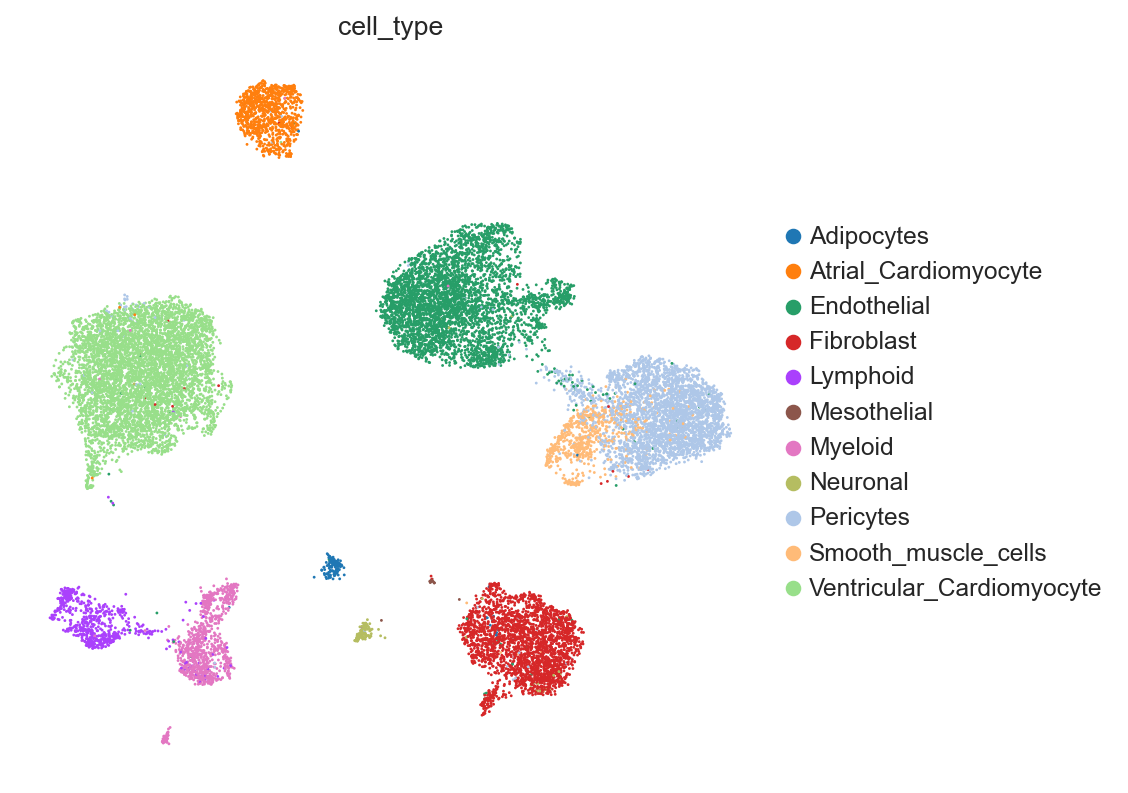

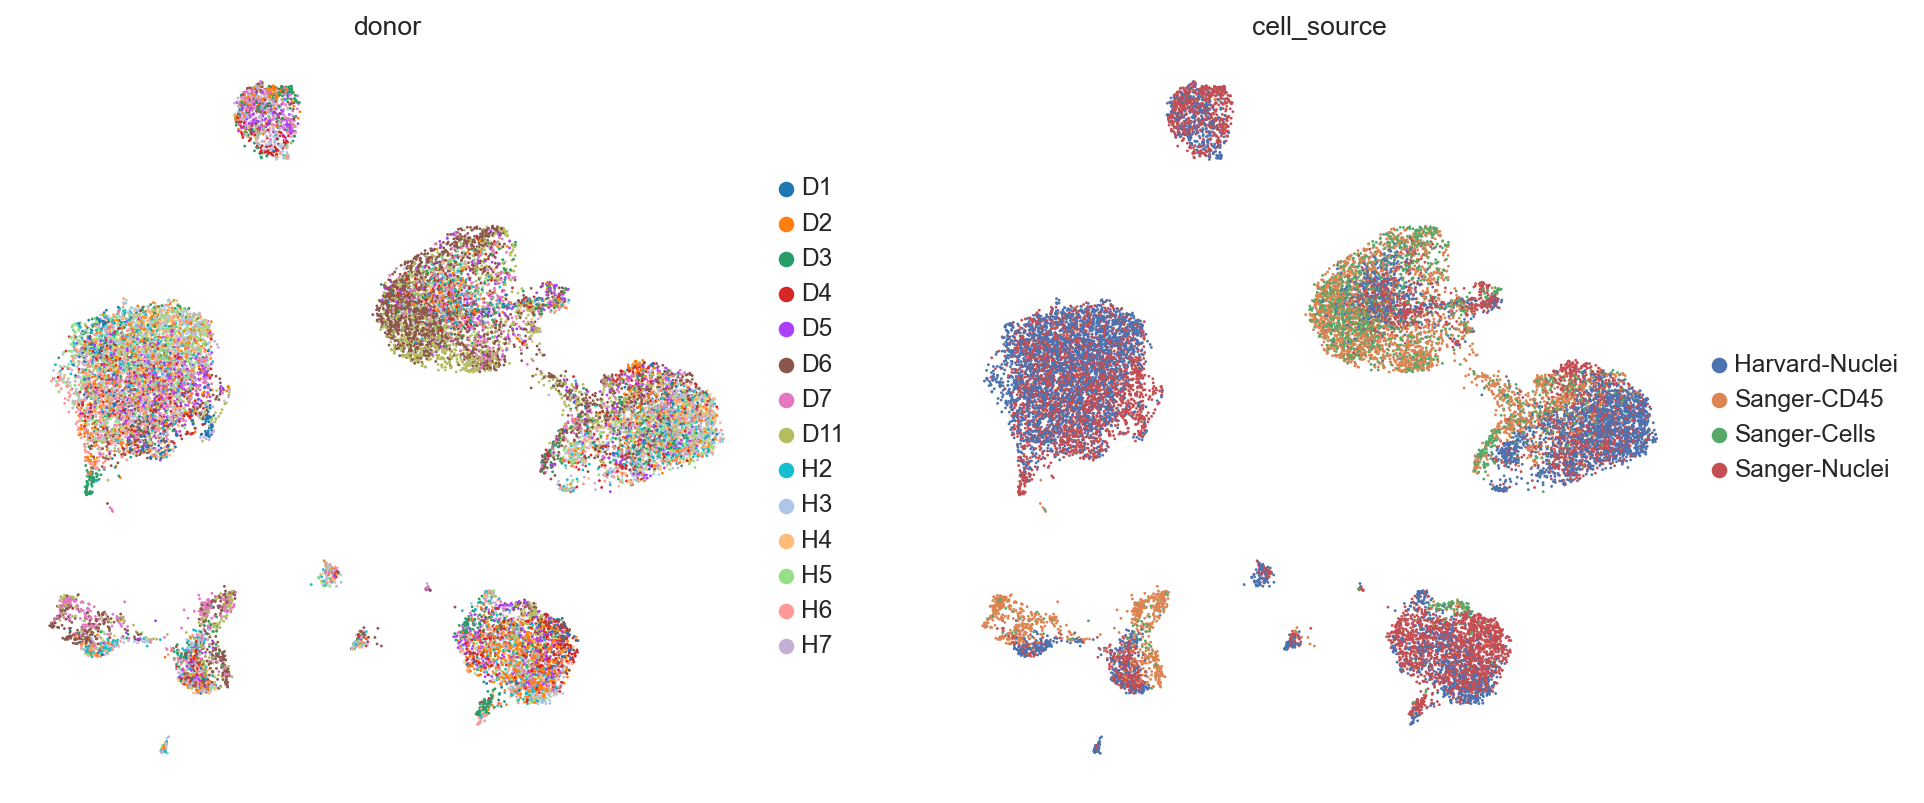

In [29]:
# solution
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

<br>


### <font color='blue'>[Q]</font>   What difference do we observe when comparing the PCA and scVI embedded UMAPS?

Solution:
We can see that scVI was able to correct for nuisance variation due to the donor and cell source while maintaining separation of cell types.


## Clustering on the scVI embeddings

In [30]:
# neighbors were already computed using scVI
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)

The labels simply represent different clusters of cells identified through analysis, with each cluster grouping cells that share similar gene expression profiles. These labels themselves do not imply biological significance and require further investigation to assign specific cell types or functions.

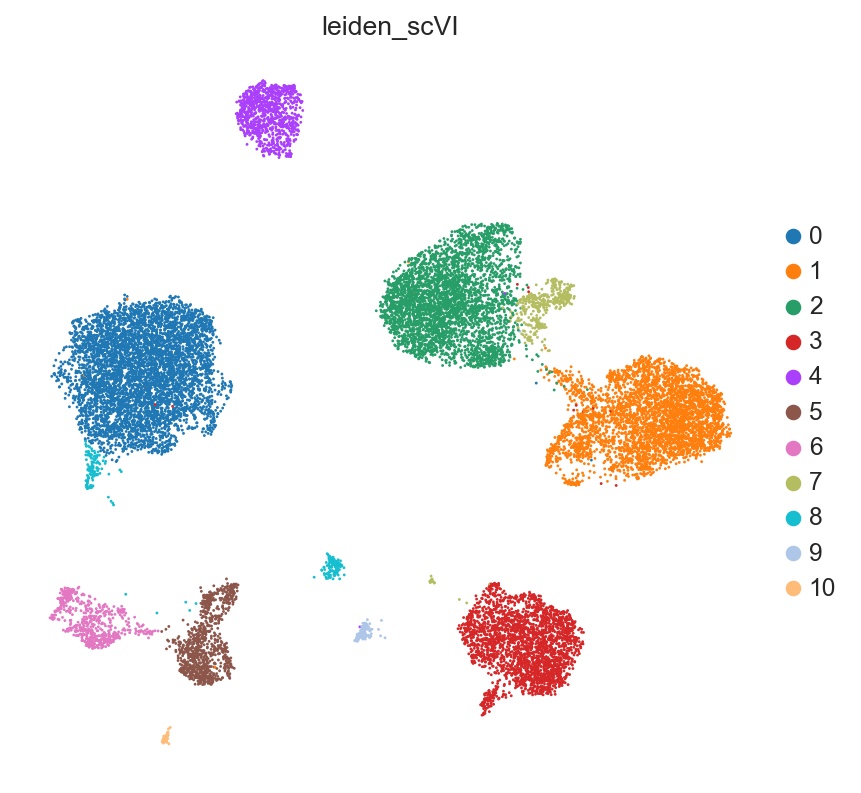

In [31]:
sc.pl.umap(
    adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False
)

In [32]:
de_df = model.differential_expression(
    groupby="leiden_scVI"
)
de_df.head()

DE...: 100%|████████████████████████████████████| 11/11 [00:05<00:00,  2.17it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
C15orf41,0.9964,0.0036,5.623212,0.011198,0.000702,0.0,0.25,5.127131,4.909469,2.251298,...,3.976304,0.118262,0.844101,0.076303,105.557762,6.039329,True,0 vs Rest,0,Rest
FYB2,0.9958,0.0042,5.468460,0.003181,0.000190,0.0,0.25,6.205997,5.761592,3.154390,...,1.216672,0.026206,0.540690,0.020233,30.400766,1.092044,True,0 vs Rest,0,Rest
LINC02552,0.9952,0.0048,5.334326,0.002237,0.000061,0.0,0.25,7.863783,7.510770,3.988181,...,0.636932,0.006047,0.258243,0.004928,18.083427,0.382338,True,0 vs Rest,0,Rest
GALNT17,0.9950,0.0050,5.293303,0.008363,0.000516,0.0,0.25,6.298884,5.908803,3.357089,...,2.922380,0.077497,0.752049,0.035538,77.501091,3.042588,True,0 vs Rest,0,Rest
BDNF,0.9930,0.0070,4.954819,0.000733,0.000064,0.0,0.25,4.772060,4.686500,2.261744,...,0.240519,0.009781,0.159901,0.006122,5.710325,0.335530,True,0 vs Rest,0,Rest


In [33]:
markers = {} # Dictionary to save the markers
cats = adata.obs['leiden_scVI'].cat.categories
for c in cats:
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0] 
    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3] 
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1] 
    
    markers[c] = cell_type_df.index.tolist()[:10]
print('Marker genes for the different clusters')
print(markers)

Marker genes for the different clusters
{'0': ['C15orf41', 'FYB2', 'LINC02552', 'GALNT17', 'BDNF', 'LINC02248', 'SORBS2', 'CDH2', 'NRAP', 'MYOZ2'], '1': ['ISYNA1', 'NOTCH3', 'CPE', 'GPAT2', 'HIGD1B', 'RGS5', 'AGT', 'KCNE4', 'ACTA2', 'MAP1B'], '2': ['FCN3', 'SLC9A3R2', 'F8', 'EGFL7', 'VWF', 'CXCL2', 'CLDN5', 'SOX17', 'TNNT3', 'IFI27'], '3': ['CDH19', 'BICC1', 'MEG3', 'MGST1', 'NEGR1', 'ABCA8', 'ABCA6', 'DCN', 'FBN1', 'NLGN4X'], '4': ['MYL7', 'SYNPR', 'KCNJ3', 'MYL4', 'ZNF385B', 'LINC02248', 'MYH6', 'OTOGL', 'CADPS', 'NPPA'], '5': ['SPI1', 'MS4A6A', 'CTSB', 'CD163', 'CLEC10A', 'FCGR2A', 'VSIG4', 'C1QB', 'MARCO', 'MS4A4A'], '6': ['KLRB1', 'CD2', 'CD69', 'CST7', 'LINC01871', 'CD3D', 'TRBC1', 'SH2D2A', 'GZMA', 'PLAC8'], '7': ['SLCO2A1', 'ACKR1', 'PKHD1L1', 'POSTN', 'PLVAP', 'ADGRG6', 'MMRN1', 'SELP', 'PTGS1', 'SELE'], '8': ['SCD', 'LVRN', 'C4orf54', 'AKR1C2', 'THRSP', 'LINC00598', 'SLC19A3', 'FLNC-AS1', 'AC022414.1', 'ADIPOQ'], '9': ['GPM6B', 'SEMA3B', 'CHL1', 'NRXN1', 'L1CAM', 'LGI4', 'ERB

### Using large language models (LLMs) for cell type annotations is an emerging research topic
$\otimes$ [GPT-4 for cell type annotations](https://www.nature.com/articles/s41592-024-02235-4), [Geneformer](https://www.nature.com/articles/s41586-023-06139-9) and [scGPT](https://www.nature.com/articles/s41592-024-02201-0#Sec14) are two such model. They are pre-trained on databases single-cell transcriptomes which can be used for other downstrean analysis.

Lets inspect if Chatgpt can determine the cell type based on the cluster markers

Lets use the following prompt to Chatgpt along with the dictionary of markers to see if it can infer the correct cell types
>  Name the cell types from the differentially expressed analysis found after clustering scRNA-seq data. The data is from heart tissue. list the cell types corresponding to the clusters and explain briefly why so. Also provide a dictionary of the annotated cell type.
{'0': ['C15orf41', 'FYB2', 'LINC02248', 'GALNT17', 'LINC02552', 'BDNF', 'RYR2', 'SORBS2', 'CDH2', 'MLIP-AS1'], '1': ['SLC9A3R2', 'EGFL7', 'CLDN5', 'FCN3', 'SOX17', 'VWF', 'CXCL2', 'IFI27', 'F8', 'PECAM1'], '2': ['HIGD1B', 'CPE', 'ISYNA1', 'GPAT2', 'RGS5', 'NOTCH3', 'AGT', 'KCNJ8', 'STEAP4', 'KCNE4'], '3': ['CDH19', 'NEGR1', 'MEG3', 'MGST1', 'BICC1', 'FBN1', 'GLIS3', 'NLGN4X', 'C3', 'COL6A3'], '4': ['MYL7', 'SYNPR', 'MYL4', 'KCNJ3', 'MYH6', 'ZNF385B', 'OTOGL', 'LINC02248', 'CADPS', 'NPPA'], '5': ['MS4A6A', 'SPI1', 'CTSB', 'FCGR2A', 'MS4A4A', 'CD163', 'C1QB', 'VSIG4', 'HMOX1', 'MARCO'], '6': ['KLRB1', 'CD69', 'CD2', 'TRBC1', 'GZMA', 'GZMK', 'RAC2', 'GZMH', 'CD3D', 'CCL5'], '7': ['MYH11', 'TAGLN', 'WFDC1', 'ACTG2', 'ID4', 'ACTA2', 'MYLK', 'KCNMB1', 'PHLDA2', 'NET1'], '8': ['PLVAP', 'ACKR1', 'PTGS1', 'PKHD1L1', 'SLCO2A1', 'POSTN', 'SELP', 'ADGRG6', 'MPZL2', 'CSF3'], '9': ['XIRP2', 'FLNC-AS1', 'C4orf54', 'ATP6V1FNB', 'KCP', 'FLNC', 'AC078980.1', 'LINC01411', 'DLG1', 'AC009318.1'], '10': ['GPM6B', 'SEMA3B', 'CHL1', 'L1CAM', 'PLP1', 'NRXN1', 'ERBB3', 'LGI4', 'PTPRZ1', 'XKR4'], '11': ['GPAM', 'SLC19A3', 'ARHGAP20', 'CIDEC', 'PLIN1', 'GPD1', 'PNPLA3', 'LGALS12', 'ACSL1', 'ADIPOQ'], '12': ['HPGDS', 'KIT', 'CPA3', 'NTM', 'SLC24A3', 'MS4A4E', 'AC092979.1', 'HPGD', 'MCTP2', 'ALOX5']}

In [34]:

# The dictionary that chatgpt provides
chatgpt_annotation_dict = {
    '0': 'Cardiomyocytes',
    '1': 'Endothelial Cells',
    '2': 'Pericytes',
    '3': 'Fibroblasts',
    '4': 'Atrial Cardiomyocytes',
    '5': 'Macrophages',
    '6': 'T cells (Cytotoxic)',
    '7': 'Smooth Muscle Cells',
    '8': 'Endothelial Cells (Venous)',
    '9': 'Striated Muscle Cells',
    '10': 'Schwann Cells',
    '11': 'Adipocytes',
    '12': 'Mast Cells'
}
adata.obs['chatgpt_annotation']  = adata.obs['leiden_scVI'].replace(chatgpt_annotation_dict)

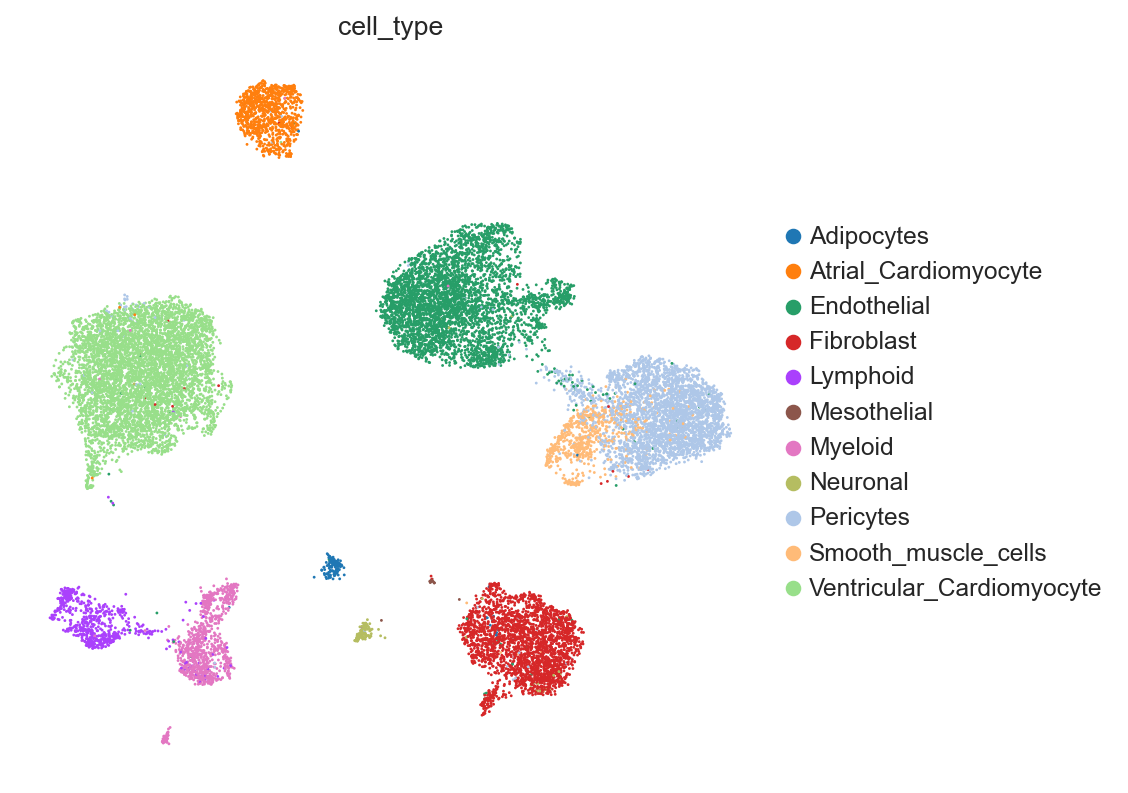

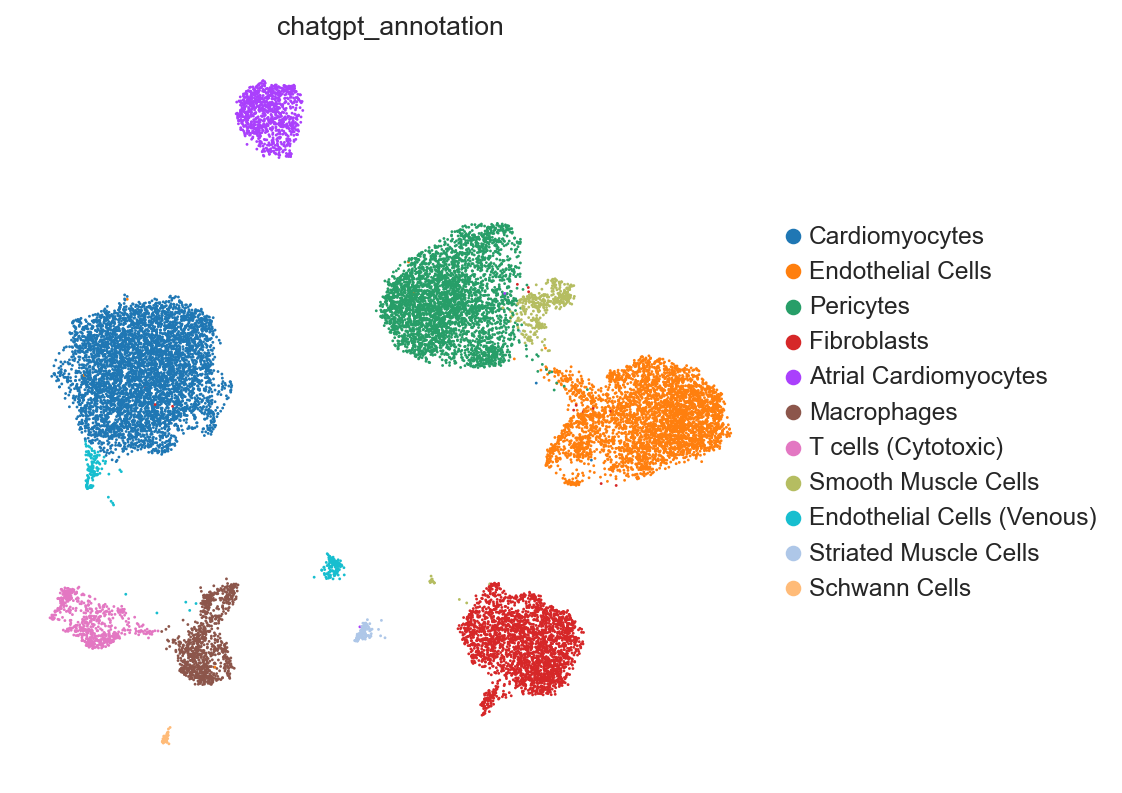

In [35]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["chatgpt_annotation"],
    frameon=False,
)

Comparing the Chatgpt annotations with the annotations we already have, we see that certain cell types are labeled correctly while others are incorrect, but roughly in the right directions. Overall, we can use such tools as a starting point or to point us in the right direction if used correctly.

- Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., ... & Teichmann, S. A. (2020). Cells of the adult human heart. Nature.
- Lopez, R., Regier, J., Cole, M. B.,  Jordan, M. I. & Yosef,  N. (2018). Deep generative modeling for single-cell transcriptomics. Nature Methods.
- Fig. 1, [Animal cell](https://www.bbc.co.uk/bitesize/articles/zkm7wnb)
- Fig. 2, [Batch correction](https://www.10xgenomics.com/analysis-guides/introduction-batch-effect-correction)
- Fig. 5, [Heart cells](https://www.mdpi.com/2075-4426/13/8/1237)